### Prepare

In [1]:
#coutils package
!pip install git+https://github.com/Mooozer/starterCode_-fromJohnson
import coutils
from coutils import fix_random_seed

  Cloning https://github.com/Mooozer/starterCode_-fromJohnson to /tmp/pip-req-build-edk_5_gf
  Running command git clone -q https://github.com/Mooozer/starterCode_-fromJohnson /tmp/pip-req-build-edk_5_gf
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=1125dd556ea153bd21a02be3253c9796dedbcae6e29049a5c09ca2137467b242
  Stored in directory: /tmp/pip-ephem-wheel-cache-gc7e85o1/wheels/33/99/25/c7b075b8e2708cf81105eb4209afcb8720adb16a42675822dc
Successfully built Colab-Utils


In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [3]:
# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

### Load Data

In [26]:
from google.colab import files
uploaded = files.upload()  #merged_sur_hrv_hr.csv  and  rrdata.csv

Saving merged_sur_hrv_hr.csv to merged_sur_hrv_hr (1).csv


In [4]:
rrdata = pd.read_csv('rrdata.csv')
data = pd.read_csv('merged_sur_hrv_hr.csv')
data['time_of_day'] = data['time_of_day'].map( {'morning':0 , 'day':1, 'evening':2, 'night':3} )

In [5]:
data0 = data[['time_of_day','heart_rate', 'bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']]
data1 = data[['time_of_day','bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']]
data2 = data[['time_of_day','bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'class4']]

data3 = data[['bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'class4']]

### Point Data and Sequence Data

In [6]:
N, T, C= 1489, 100, 4

##Point Features:
rr_features = pd.DataFrame({'rr_var' : []}) 
#Variance: the average of the squared differences from the mean
rr_features['rr_var'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).var(axis=1)
#Skewness, a measure of symmetry:
rr_features['rr_skew'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).skew(axis=1)
#Kurtosis: How heavily the tails of a distribution differ from the tails of a normal distribution:
rr_features['rr_kurt'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).kurtosis(axis=1)

ori_point_features = data1.drop(['class4'], axis=1) #original point features
Pointdata = torch.tensor(pd.concat([ori_point_features, rr_features],axis=1).values).to(torch.float) #(1489, 25)
Pointdata = (Pointdata-Pointdata.min(0, keepdim=True).values)/(Pointdata.max(0, keepdim=True).values - Pointdata.min(0, keepdim=True).values) #Rescale 


##Sequence Features:  
rr_diff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).diff(periods=-1, axis=1)*(-1) 
rr_diff['rr99'] = 1/3*(rr_diff['rr98'] + rr_diff['rr97'] + rr_diff['rr96'])
rr_diff_tensor = torch.tensor(rr_diff.values).to(torch.float)
rr_diff_tensor = (rr_diff_tensor-rr_diff_tensor.min(0, keepdim=True).values)/(rr_diff_tensor.max(0, keepdim=True).values - rr_diff_tensor.min(0, keepdim=True).values) #Rescale 
rr_diff_tensor = rr_diff_tensor.reshape(N,T,1)

rr = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1) #original seq features
rr_tensor = torch.tensor(rr.values).to(torch.float)
rr_tensor = (rr_tensor-rr_tensor.min(0, keepdim=True).values)/(rr_tensor.max(0, keepdim=True).values - rr_tensor.min(0, keepdim=True).values) #Rescale 
rr_tensor = rr_tensor.reshape(N,T,1)
Seqdata = torch.cat((rr_tensor, rr_diff_tensor), 2) #(1489, 100, 2)

##Class label:  
class_y = torch.tensor(data1['class4'].values)  #(N=1489, )

print("Pointdata:", Pointdata.shape, Pointdata.dtype)
print("Seqdata:", Seqdata.shape, Seqdata.dtype)
print("class_y:", class_y.shape, class_y.dtype)



Pointdata: torch.Size([1489, 25]) torch.float32
Seqdata: torch.Size([1489, 100, 2]) torch.float32
class_y: torch.Size([1489]) torch.int64


### LSTM

In [7]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn=None, Wattn=None):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D(number of sequences is D), the hidden state has dimension H=1, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H=1)
    - prev_c: previous cell state, of shape (N, H=1)
    - Wx: Input-to-hidden weights, of shape (D, 4H=4)
    - Wh: Hidden-to-hidden weights, of shape (H=1, 4H=4)
    - b: Biases, of shape (4H=4,)      
    
    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    """
    next_h, next_c = None, None
    N,D = x.shape 
    N,H = prev_h.shape
    A = x.mm(Wx) +  prev_h.mm(Wh)  + b 
    a_i , a_f, a_o, a_g =  A[:,0:H], A[:,H:2*H], A[:,2*H:3*H], A[:,3*H:4*H]
    i, f, o, g = torch.sigmoid(a_i),torch.sigmoid(a_f),torch.sigmoid(a_o), torch.tanh(a_g)
    next_c = f * prev_c + i * g 
    next_h = o * torch.tanh(next_c)
    return next_h, next_c

In [8]:
def lstm_forward(x, h0, Wx, Wh, b, outT):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H=1, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, D)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H=4)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H=4)
    - b: Biases, of shape (4H=4,)
    - outT: how many timesteps returned of the hidden states

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H=1)
    """
    h = None
    c0 = torch.zeros_like(h0) #the intial cell state c0 
    N, T, D = x.shape
    H = Wh.shape[0]
    h = torch.zeros(N, T, H , **to_float_cuda)
    prev_h = h0
    prev_c = c0 
    for t in range(T):
      A = x[:, t, :].mm(Wx) +  prev_h.mm(Wh) + b 
      a_i , a_f, a_o, a_g =  A[:,0:H], A[:,H:2*H], A[:,2*H:3*H], A[:,3*H:4*H]
      i, f, o, g = torch.sigmoid(a_i), torch.sigmoid(a_f), torch.sigmoid(a_o), torch.tanh(a_g)
      next_c = f * prev_c + i * g 
      next_h = o * torch.tanh(next_c)
      h[:, t, :] = next_h        
      prev_h, prev_c = next_h , next_c
    outIndex = [int(i) for i in np.linspace(0,100,num=outT+1,endpoint=False,retstep=True)[0][1:]] #len = outT
    h = h[:, outIndex, :]  #(N, outT, H)
    return h

### Loss

In [9]:
def softmax_loss(x, y):
    """
    Inputs:
    - x: Input scores, of shape (N, C=4) 
    - y: Ground-truth indices, of shape (N, ) where each element is in the range 1 <= y[i] <= 4

    Returns:
    - loss: Scalar giving loss
    """
    loss = None    
    N, C = x.shape[0], x.shape[1]  
    loss = F.cross_entropy(x, y, reduction='sum') * 1. / N   
    return loss

### RNN-DNN Model

In [10]:
class RNN_DNN(nn.Module):
    def __init__(self, input_dim=1, input_dim_v=4, input_dim_t=100, C=4, hidden_dim=1, proj_dim=1, 
                 DNN_hidden_Size=[10,5], reg=0.0, cell_type='lstm', dropratio=0.5, device='cuda', dtype=torch.float):
        """
        Inputs:
        - input_dim: Dimension D of input(number of sequence) 
        - input_dim_v: number of point features
        - input_dim_t: length of time for sequence features 
        - C: number of classes 
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - DNN_hidden_Size: list, dimension of DNN hidden layers
        - reg: regularization parameter
        - cell_type: What type of RNN to use: 'lstm'
        - device: 'cuda' or 'cpu'
        - dtype: datatype to use
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)
        
        self.input_dim = input_dim
        self.H = hidden_dim
        self.V = input_dim_v
        self.T = input_dim_t
        self.C = C 
        self.P = proj_dim
        self.DNN_hidden_Size = DNN_hidden_Size
        self.dtype = dtype
        self.device = device
        self.cell_type = cell_type
        self.reg = reg 
        self.dropratio = dropratio

        # Initialize parameters for the RNN / LSTM  
        fac = {'rnn':1, 'lstm':4}[self.cell_type]
        self.Wx = Parameter(torch.randn(input_dim, fac * self.H, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.Wh = Parameter(torch.randn(self.H, fac * self.H, device=device, dtype=dtype).div(math.sqrt(self.H)))
        self.b = Parameter(torch.zeros(fac * self.H, device=device, dtype=dtype))

        #Initialize RNN output multi-state(N,T,H=1) -> single state(N,H=1) projection parameters: 
        self.W_proj = Parameter(torch.randn(self.T, self.P, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.b_proj = Parameter(torch.zeros(self.P, device=device, dtype=dtype))

        #Initialize parameters for DNN 
        W_d1 = Parameter(torch.randn(self.V+self.P, self.DNN_hidden_Size[0], device=device, dtype=dtype).div(math.sqrt(self.V + self.P)))
        exec(f'self.W_d{1} = W_d1') 
        b_d1 = Parameter(torch.zeros(self.DNN_hidden_Size[0], device=device, dtype=dtype))
        exec(f'self.b_d{1} = b_d1') 
        for i in range(2,len(self.DNN_hidden_Size)+1):
          W_di = Parameter(torch.randn(self.DNN_hidden_Size[i-2], self.DNN_hidden_Size[i-1], device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[i-2])))
          exec(f'self.W_d{i} = W_di')   
          b_di = Parameter(torch.zeros(self.DNN_hidden_Size[i-1], device=device, dtype=dtype)) 
          exec(f'self.b_d{i} = b_di')   
        W_dlast = Parameter(torch.randn(self.DNN_hidden_Size[-1], self.C, device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[-1])))
        exec(f'self.W_d{len(self.DNN_hidden_Size)+1} = W_dlast')   
        b_dlast = Parameter(torch.zeros(self.C, device=device, dtype=dtype))
        exec(f'self.b_d{len(self.DNN_hidden_Size)+1} = b_dlast')   
 
    
    def train_process(self):
      raise NotImplementedError
    
    def test_process(self):
      raise NotImplementedError



In [11]:
    def RNN_DNN_forward(self, Pointdata, Seqdata, y):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)
        - y: (N,)

        Outputs:
        - loss: A scalar loss
        """

        loss = 0.0
        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)
        groundTruth_y = y.to(torch.long).to(self.device) #(N,)

        #(1) h0
        A0 = Seqdata[:,0,:].mm(self.Wx) #(N,4H)
        h0 =  A0[:,0:self.H] + A0[:,self.H:2*self.H] + A0[:,2*self.H:3*self.H] + A0[:,3*self.H:4*self.H]


        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 

        N = Pointdata.shape[0]
        H = self.H
        T = self.T

        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  
        single_state = F.dropout(single_state, p=self.dropratio) 

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        DNNhidden = F.dropout(DNNhidden, p=self.dropratio)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01) # DNNhidden = torch.relu(DNNhidden)  #
          DNNhidden = F.dropout(DNNhidden, p=self.dropratio) 
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

        #(5)
        loss = softmax_loss(DNNoutput, groundTruth_y)
        loss +=self.reg * torch.sum(self.Wx*self.Wx) + self.reg * torch.sum(self.Wh*self.Wh) #regularization 
        loss +=self.reg * torch.sum(self.W_proj*self.W_proj) #regularization 
      
        return loss

    RNN_DNN.train_process = RNN_DNN_forward

In [12]:
    def RNN_DNN_test(self, Pointdata, Seqdata, y):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)

        Outputs:
        - scalar: classficition 
        """

        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)
        groundTruth_y = y.to(torch.long).to(self.device) #(N,)

        #(1) h0
        A0 = Seqdata[:,0,:].mm(self.Wx) #(N,4H)
        h0 =  A0[:,0:self.H] + A0[:,self.H:2*self.H] + A0[:,2*self.H:3*self.H] + A0[:,3*self.H:4*self.H]

        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 
       
        N = Pointdata.shape[0]
        H = self.H 
        T = self.T
        
        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01)  #DNNhidden = torch.relu(DNNhidden) 
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  
                
        #(5)
        pred_y = DNNoutput.argmax(dim=1)
    
        return  pred_y

    RNN_DNN.test_process = RNN_DNN_test

### Training

In [24]:
def ModelTrain(rnndnn_model, Point_data, Seq_data, y_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnndnn_model.parameters()), learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(Point_data.shape[0] // batch_size)
  loss_history = []
  rnndnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      PointData = Point_data[j*batch_size:(j+1)*batch_size]
      SeqData =  Seq_data[j*batch_size:(j+1)*batch_size]
      y = y_data[j*batch_size:(j+1)*batch_size]

      loss = rnndnn_model.train_process(PointData, SeqData, y)
      optimizer.zero_grad() 
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(i, num_epochs, loss.item(), end_t-start_t))
    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history, color='black')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()



In [14]:
from sklearn.model_selection import train_test_split
Pointdata_train, Pointdata_test, Seqdata_train, Seqdata_test, class_y_train, class_y_test = train_test_split(Pointdata, Seqdata, class_y, test_size=0.2, random_state=6)

Pointdata_train, Pointdata_test = Pointdata_train.to(torch.float), Pointdata_test.to(torch.float)
Seqdata_train, Seqdata_test = Seqdata_train.to(torch.float), Seqdata_test.to(torch.float)

#Pointdata_train, Pointdata_test = Pointdata_train.to(torch.float), Pointdata_test.to(torch.float)
#Seqdata_train, Seqdata_test = Seqdata_train.to(torch.float), Seqdata_test.to(torch.float)

print("Pointdata_train:", Pointdata_train.shape, Pointdata_train.dtype)  #(1191, 25)
print("Pointdata_test:", Pointdata_test.shape, Pointdata_test.dtype)     #(298, 25)
print("Seqdata_train:", Seqdata_train.shape, Seqdata_train.dtype)        #(1191, 100, 2)
print("Seqdata_test:", Seqdata_test.shape, Seqdata_test.dtype)           #(298, 100, 2)
print("class_y_train:", class_y_train.shape, class_y_train.dtype)        #(1191,) 
print("class_y_test:", class_y_test.shape, class_y_test.dtype)           #(298, )


Pointdata_train: torch.Size([1191, 25]) torch.float32
Pointdata_test: torch.Size([298, 25]) torch.float32
Seqdata_train: torch.Size([1191, 100, 2]) torch.float32
Seqdata_test: torch.Size([298, 100, 2]) torch.float32
class_y_train: torch.Size([1191]) torch.int64
class_y_test: torch.Size([298]) torch.int64


Streaming output truncated to the last 5000 lines.
(Epoch 0 / 5000) loss: 1.5277 time per epoch: 0.1s
(Epoch 1 / 5000) loss: 2.2243 time per epoch: 0.1s
(Epoch 2 / 5000) loss: 1.4479 time per epoch: 0.1s
(Epoch 3 / 5000) loss: 1.4200 time per epoch: 0.1s
(Epoch 4 / 5000) loss: 1.4254 time per epoch: 0.1s
(Epoch 5 / 5000) loss: 1.3997 time per epoch: 0.1s
(Epoch 6 / 5000) loss: 1.3914 time per epoch: 0.1s
(Epoch 7 / 5000) loss: 1.3738 time per epoch: 0.1s
(Epoch 8 / 5000) loss: 1.3601 time per epoch: 0.1s
(Epoch 9 / 5000) loss: 1.3610 time per epoch: 0.1s
(Epoch 10 / 5000) loss: 1.3619 time per epoch: 0.1s
(Epoch 11 / 5000) loss: 1.3677 time per epoch: 0.1s
(Epoch 12 / 5000) loss: 1.3652 time per epoch: 0.1s
(Epoch 13 / 5000) loss: 1.3578 time per epoch: 0.1s
(Epoch 14 / 5000) loss: 1.3617 time per epoch: 0.1s
(Epoch 15 / 5000) loss: 1.3558 time per epoch: 0.1s
(Epoch 16 / 5000) loss: 1.3595 time per epoch: 0.1s
(Epoch 17 / 5000) loss: 1.3576 time per epoch: 0.1s
(Epoch 18 / 5000) loss:

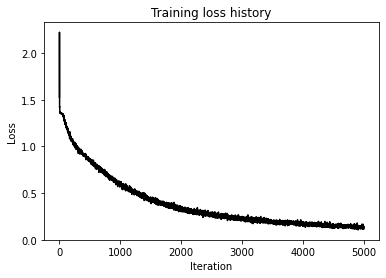

In [40]:
num_epochs = 5000
batch_size = 1191 

# create the RNN_DNN model
rnn_dnn_model = RNN_DNN(
          cell_type='lstm',
          input_dim = 2,     #Seqdata_train.shape[2]
          input_dim_v = 25,  #Pointdata_train.shape[1],
          input_dim_t= 50,   #Seqdata_train.shape[1], 
          proj_dim = 10,
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.5, 
          DNN_hidden_Size=[256, 1024, 2048, 1024, 512],  #str11
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  ModelTrain(rnn_dnn_model, Pointdata_train, Seqdata_train, class_y_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Testing

In [41]:
rnn_dnn_model = rnn_dnn_model.eval()  
y_pred_train = rnn_dnn_model.test_process(Pointdata_train, Seqdata_train, class_y_train)
y_pred_train= y_pred_train.to('cpu')

y_pred = rnn_dnn_model.test_process(Pointdata_test, Seqdata_test,class_y_test)
y_pred = y_pred.to('cpu')
y_pred

tensor([0, 0, 0, 2, 2, 2, 3, 1, 0, 3, 2, 2, 0, 2, 1, 3, 0, 2, 3, 0, 2, 0, 2, 0,
        2, 2, 3, 3, 0, 0, 2, 1, 3, 3, 3, 3, 2, 1, 2, 3, 3, 2, 1, 2, 2, 2, 0, 0,
        3, 2, 3, 1, 0, 0, 3, 1, 0, 3, 3, 0, 2, 1, 2, 3, 3, 0, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 0, 3, 2, 3, 2, 0, 3, 3, 3, 3, 2, 1, 3, 0, 2, 2, 2, 2, 0, 1, 1,
        2, 2, 0, 2, 0, 1, 2, 0, 3, 3, 2, 0, 2, 2, 2, 2, 3, 2, 2, 0, 1, 3, 1, 2,
        2, 1, 2, 2, 0, 2, 3, 2, 0, 2, 0, 2, 0, 3, 3, 0, 2, 1, 0, 2, 3, 0, 0, 2,
        2, 2, 2, 1, 0, 3, 1, 2, 0, 3, 0, 2, 1, 0, 0, 2, 3, 2, 2, 0, 3, 0, 0, 2,
        0, 3, 0, 3, 1, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 3, 2, 3, 0, 0,
        3, 2, 0, 0, 3, 3, 2, 0, 3, 3, 2, 3, 2, 3, 2, 2, 0, 2, 1, 3, 0, 0, 0, 3,
        0, 2, 2, 2, 2, 0, 2, 0, 2, 3, 3, 1, 1, 3, 1, 0, 2, 1, 0, 1, 2, 0, 0, 2,
        0, 3, 2, 0, 1, 2, 1, 0, 2, 3, 3, 0, 3, 2, 2, 3, 2, 3, 3, 0, 3, 0, 2, 0,
        0, 1, 0, 0, 1, 1, 3, 3, 2, 3, 2, 0, 0, 2, 2, 0, 3, 1, 0, 0, 0, 3, 1, 0,
        0, 1, 2, 3, 3, 2, 0, 3, 1, 0])

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
print('-----------test-------------')
print(confusion_matrix(class_y_test,y_pred))
print(classification_report(class_y_test,y_pred))
print('-----------train-------------')
print(confusion_matrix(class_y_train,y_pred_train))
print(classification_report(class_y_train,y_pred_train))

-----------test-------------
[[76  6  0  1]
 [ 9 29  1  2]
 [ 1  1 98  7]
 [ 0  1  1 65]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        83
           1       0.78      0.71      0.74        41
           2       0.98      0.92      0.95       107
           3       0.87      0.97      0.92        67

    accuracy                           0.90       298
   macro avg       0.88      0.88      0.88       298
weighted avg       0.90      0.90      0.90       298

-----------train-------------
[[341   2   0   2]
 [ 18 158   0   2]
 [  0   0 359   1]
 [  3   1   0 304]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       345
           1       0.98      0.89      0.93       178
           2       1.00      1.00      1.00       360
           3       0.98      0.99      0.99       308

    accuracy                           0.98      1191
   macro avg       0.98      0.97      0.9

In [19]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, auc, roc_curve

accuracy_score = accuracy_score(class_y_test, y_pred) 
precision_score = precision_score(class_y_test, y_pred, average='weighted') 
recall_score = recall_score(class_y_test, y_pred, average='weighted') 
f1_score = f1_score(class_y_test, y_pred, average='weighted') 
Multi_auc = multiclass_roc_auc_score(class_y_test,y_pred)
print("accuracy_score",round(accuracy_score,3))
print("precision_score", round(precision_score,3))
print("recall_score", round(recall_score,3))
print("f1_score", round(f1_score,3))
print("Multi_auc",round(Multi_auc,3))

accuracy_score 0.768
precision_score 0.761
recall_score 0.768
f1_score 0.76
Multi_auc 0.824


################################################################
#  UQ   
################################################################

In [ ]:
#Start Training
num_epochs = 1000 
batch_size = 1191 

# create the RNN_DNN model
rnn_dnn_model_START = RNN_DNN(
          cell_type='lstm',
          input_dim = 2,     #Seqdata_train.shape[2]
          input_dim_v = 25,  #Pointdata_train.shape[1],
          input_dim_t= 50,   #Seqdata_train.shape[1], 
          proj_dim = 10,
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.5, 
          DNN_hidden_Size=[256, 1024, 2048, 1024, 512],  #str11
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  ModelTrain(rnn_dnn_model_START, Pointdata_train, Seqdata_train, class_y_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

In [26]:
Stored_Para = {}
for name, param in rnn_dnn_model_START.named_parameters():
  Stored_Para[name] = param

In [27]:
class RNN_DNN_UQ(nn.Module):
    def __init__(self, input_dim=1, input_dim_v=4, input_dim_t=100, C=4, hidden_dim=1, proj_dim=1, 
                 DNN_hidden_Size=[10,5], reg=0.0, cell_type='lstm', dropratio=0.5, device='cuda', dtype=torch.float):
        """
        Inputs:
        - input_dim: Dimension D of input(number of sequence) 
        - input_dim_v: number of point features
        - input_dim_t: length of time for sequence features 
        - C: number of classes 
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - DNN_hidden_Size: list, dimension of DNN hidden layers
        - reg: regularization parameter
        - cell_type: What type of RNN to use: 'lstm'
        - device: 'cuda' or 'cpu'
        - dtype: datatype to use
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)
        
        self.input_dim = input_dim
        self.H = hidden_dim
        self.V = input_dim_v
        self.T = input_dim_t
        self.C = C 
        self.P = proj_dim
        self.DNN_hidden_Size = DNN_hidden_Size
        self.dtype = dtype
        self.device = device
        self.cell_type = cell_type
        self.reg = reg 
        self.dropratio = dropratio

        # Initialize parameters for the RNN / LSTM  
        fac = {'rnn':1, 'lstm':4}[self.cell_type]
        self.Wx = Stored_Para['Wx']
        self.Wh = Stored_Para['Wh']
        self.b = Stored_Para['b']

        #Initialize RNN output multi-state(N,T,H=1) -> single state(N,H=1) projection parameters: 
        self.W_proj = Stored_Para['W_proj']
        self.b_proj = Stored_Para['b_proj']

        #Initialize parameters for DNN 
        W_d1 = Stored_Para['W_d1']
        exec(f'self.W_d{1} = W_d1') 
        b_d1 = Stored_Para['b_d1']
        exec(f'self.b_d{1} = b_d1') 
        for i in range(2,len(self.DNN_hidden_Size)+1):
          W_di = Stored_Para['W_d'+str(i)]
          exec(f'self.W_d{i} = W_di')   
          b_di = Stored_Para['b_d'+str(i)]
          exec(f'self.b_d{i} = b_di')   
        W_dlast = Stored_Para['W_d'+str(i+1)]
        exec(f'self.W_d{len(self.DNN_hidden_Size)+1} = W_dlast')   
        b_dlast = Stored_Para['b_d'+str(i+1)]
        exec(f'self.b_d{len(self.DNN_hidden_Size)+1} = b_dlast')   
 
    
    def train_process(self):
      raise NotImplementedError
    
    def test_process(self):
      raise NotImplementedError

In [28]:
    def RNN_DNN_test_UQ(self, Pointdata, Seqdata):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)

        Outputs:
        - scalar: classficition 
        """

        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)

        #(1) h0
        A0 = Seqdata[:,0,:].mm(self.Wx) #(N,4H)
        h0 =  A0[:,0:self.H] + A0[:,self.H:2*self.H] + A0[:,2*self.H:3*self.H] + A0[:,3*self.H:4*self.H]

        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 
       
        N = Pointdata.shape[0]
        H = self.H 
        T = self.T
        
        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01)  
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

        #(5)
        pred_y = DNNoutput.argmax(dim=1)
        pred_y_prob = F.softmax(DNNoutput, dim=1)
        return pred_y, pred_y_prob

    RNN_DNN_UQ.train_process = RNN_DNN_forward
    RNN_DNN_UQ.test_process = RNN_DNN_test_UQ

------------------------- Bootstrip 0 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 1.2125 time per epoch: 0.1s
(Epoch 1 / 100) loss: 1.2249 time per epoch: 0.1s
(Epoch 2 / 100) loss: 1.2911 time per epoch: 0.1s
(Epoch 3 / 100) loss: 1.2290 time per epoch: 0.1s
(Epoch 4 / 100) loss: 1.2388 time per epoch: 0.1s
(Epoch 5 / 100) loss: 1.2202 time per epoch: 0.1s
(Epoch 6 / 100) loss: 1.2212 time per epoch: 0.1s
(Epoch 7 / 100) loss: 1.2235 time per epoch: 0.1s
(Epoch 8 / 100) loss: 1.2231 time per epoch: 0.1s
(Epoch 9 / 100) loss: 1.1968 time per epoch: 0.1s
(Epoch 10 / 100) loss: 1.2148 time per epoch: 0.1s
(Epoch 11 / 100) loss: 1.2194 time per epoch: 0.1s
(Epoch 12 / 100) loss: 1.1950 time per epoch: 0.1s
(Epoch 13 / 100) loss: 1.2185 time per epoch: 0.1s
(Epoch 14 / 100) loss: 1.2050 time per epoch: 0.1s
(Epoch 15 / 100) loss: 1.2040 time per epoch: 0.1s
(Epoch 16 / 100) loss: 1.1952 time per epoch: 0.1s
(Epoch 17 / 100) loss: 1.1870 time per epoch: 0.1s
(Epo

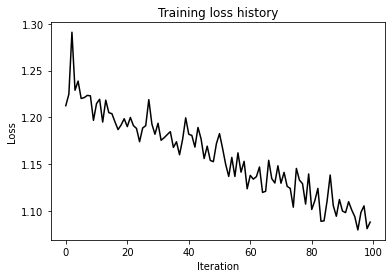

------------------------- Bootstrip 1 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 1.1353 time per epoch: 0.1s
(Epoch 1 / 100) loss: 1.1773 time per epoch: 0.1s
(Epoch 2 / 100) loss: 1.1462 time per epoch: 0.1s
(Epoch 3 / 100) loss: 1.1582 time per epoch: 0.1s
(Epoch 4 / 100) loss: 1.1364 time per epoch: 0.1s
(Epoch 5 / 100) loss: 1.1340 time per epoch: 0.1s
(Epoch 6 / 100) loss: 1.1346 time per epoch: 0.1s
(Epoch 7 / 100) loss: 1.1443 time per epoch: 0.1s
(Epoch 8 / 100) loss: 1.1244 time per epoch: 0.1s
(Epoch 9 / 100) loss: 1.1016 time per epoch: 0.1s
(Epoch 10 / 100) loss: 1.1159 time per epoch: 0.1s
(Epoch 11 / 100) loss: 1.1092 time per epoch: 0.1s
(Epoch 12 / 100) loss: 1.1296 time per epoch: 0.1s
(Epoch 13 / 100) loss: 1.1036 time per epoch: 0.1s
(Epoch 14 / 100) loss: 1.1231 time per epoch: 0.1s
(Epoch 15 / 100) loss: 1.1168 time per epoch: 0.1s
(Epoch 16 / 100) loss: 1.1026 time per epoch: 0.1s
(Epoch 17 / 100) loss: 1.1050 time per epoch: 0.1s
(Epo

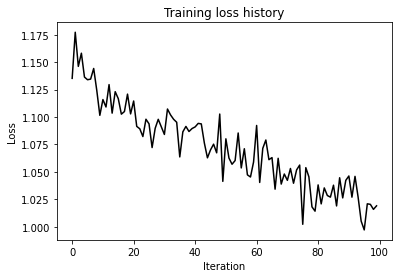

------------------------- Bootstrip 2 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.9912 time per epoch: 0.1s
(Epoch 1 / 100) loss: 1.0185 time per epoch: 0.1s
(Epoch 2 / 100) loss: 1.0039 time per epoch: 0.1s
(Epoch 3 / 100) loss: 1.0190 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.9939 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.9800 time per epoch: 0.1s
(Epoch 6 / 100) loss: 1.0198 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.9971 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.9898 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.9954 time per epoch: 0.1s
(Epoch 10 / 100) loss: 1.0112 time per epoch: 0.1s
(Epoch 11 / 100) loss: 1.0209 time per epoch: 0.1s
(Epoch 12 / 100) loss: 1.0021 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.9946 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.9912 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.9945 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.9895 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.9835 time per epoch: 0.1s
(Epo

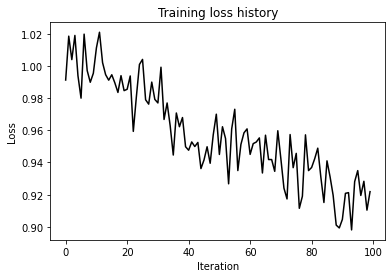

------------------------- Bootstrip 3 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.9393 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.9958 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.9641 time per epoch: 0.1s
(Epoch 3 / 100) loss: 1.0109 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.9257 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.9415 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.9408 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.9589 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.9338 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.9268 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.9230 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.9343 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.9392 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.9213 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.9140 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.9066 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.9219 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.9482 time per epoch: 0.1s
(Epo

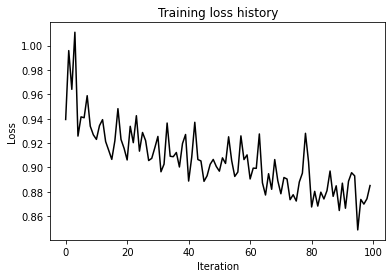

------------------------- Bootstrip 4 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.8781 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.9431 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.8990 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.9188 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.9087 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.8994 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.8633 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.8962 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.8945 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.9035 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.8977 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.8771 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.8862 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.8864 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.8605 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.8764 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.8729 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.8800 time per epoch: 0.1s
(Epo

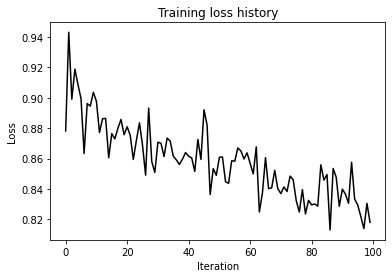

------------------------- Bootstrip 5 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.8542 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.8580 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.8394 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.8369 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.8118 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.8327 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.8492 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.8276 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.8479 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.8222 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.8354 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.8459 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.8366 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.8384 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.8501 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.8275 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.8111 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.8143 time per epoch: 0.1s
(Epo

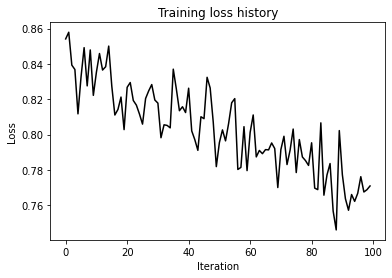

------------------------- Bootstrip 6 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.8598 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.8318 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.8325 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.8422 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.8311 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.8118 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.8037 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.8212 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.8230 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.8068 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.8201 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.8273 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.8100 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.8206 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.8092 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.8059 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.8299 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.8146 time per epoch: 0.1s
(Epo

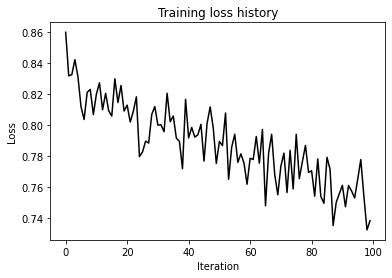

------------------------- Bootstrip 7 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.7802 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.7462 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.7313 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.7547 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.7323 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.7361 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.7263 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.7408 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.7509 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.7249 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.7497 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.7467 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.7551 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.7070 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.7428 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.7448 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.7351 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.7338 time per epoch: 0.1s
(Epo

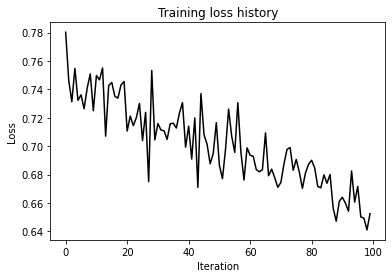

------------------------- Bootstrip 8 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.7645 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.7117 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.6983 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.7307 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.7023 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.7012 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.7097 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.7278 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.6995 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.7178 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.6908 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.6968 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.6891 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.6638 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.6709 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.6776 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.6932 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.6837 time per epoch: 0.1s
(Epo

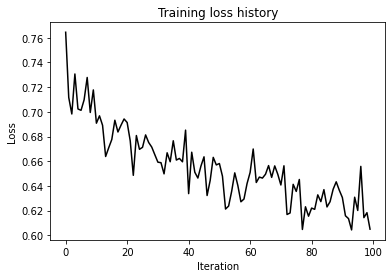

------------------------- Bootstrip 9 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.6654 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.6444 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.6750 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.6399 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.6353 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.6368 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.6306 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.6227 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.6538 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.6353 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.6326 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.6251 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.6398 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.6239 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.6275 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.6464 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.6204 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.6194 time per epoch: 0.1s
(Epo

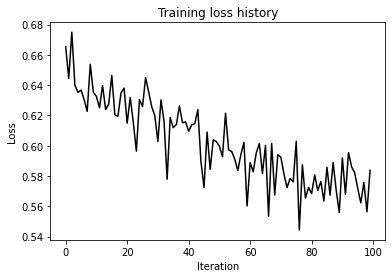

------------------------- Bootstrip 10 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.7064 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.7022 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.6364 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.6658 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.6521 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.6618 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.6511 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.6392 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.6695 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.6421 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.6228 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.6379 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.6448 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.6459 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.6524 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.6494 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.6409 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.6387 time per epoch: 0.1s
(Ep

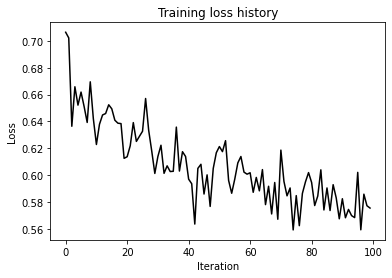

------------------------- Bootstrip 11 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.6246 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.6002 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.5799 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.5843 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.5964 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.6193 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.5874 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.6008 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.5876 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.5688 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.6013 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.5855 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.5578 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.5836 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.5877 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.5713 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.5935 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.5854 time per epoch: 0.1s
(Ep

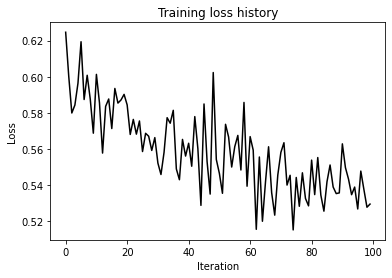

------------------------- Bootstrip 12 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.5859 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.5787 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.5615 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.5369 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.5933 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.5417 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.5575 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.5477 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.5656 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.5615 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.5410 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.5711 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.5396 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.5746 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.5258 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.5267 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.5480 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.5252 time per epoch: 0.1s
(Ep

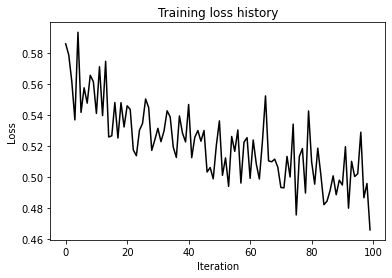

------------------------- Bootstrip 13 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.5853 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.5808 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.5814 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.5502 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.5372 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.5502 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.5555 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.5363 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.5257 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.5707 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.5344 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.5361 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.5164 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.5504 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.5435 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.5105 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.5498 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.5279 time per epoch: 0.1s
(Ep

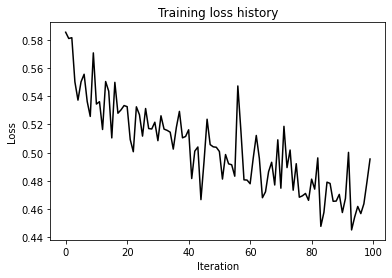

------------------------- Bootstrip 14 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.5230 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.4971 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.4891 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.4999 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.4907 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.5162 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.5062 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.5187 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.4812 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.4939 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.4694 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.4859 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.4970 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.5166 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.4935 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.4988 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.4845 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.4667 time per epoch: 0.1s
(Ep

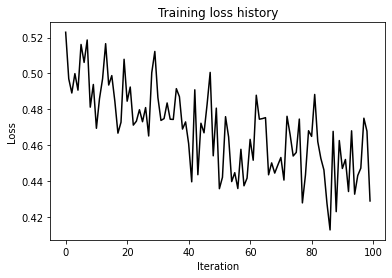

------------------------- Bootstrip 15 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.5072 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.4762 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.4870 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.4523 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.4775 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.4799 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.4426 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.4670 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.4519 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.4707 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.4585 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.4513 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.4409 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.4397 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.4456 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.4491 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.4457 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.4677 time per epoch: 0.1s
(Ep

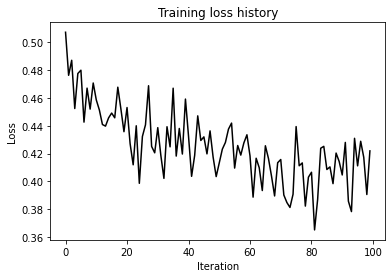

------------------------- Bootstrip 16 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.4795 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.4459 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.4906 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.4370 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.4713 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.4365 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.4508 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.4053 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.4229 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.4031 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.4270 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3971 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.4102 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.4360 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.4188 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.4168 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.4304 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3997 time per epoch: 0.1s
(Ep

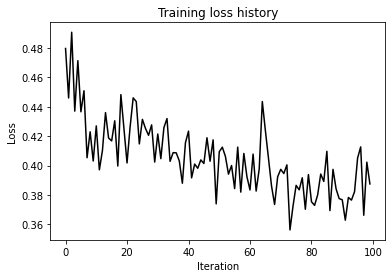

------------------------- Bootstrip 17 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.4278 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.4026 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.4215 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.4219 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3956 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.4045 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.4311 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3721 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3698 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3880 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3862 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.4134 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.4004 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3424 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3901 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3817 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3898 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3464 time per epoch: 0.1s
(Ep

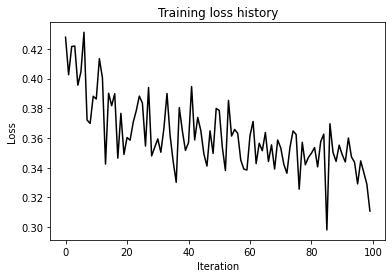

------------------------- Bootstrip 18 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.4194 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.4229 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.4233 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.4263 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.4086 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3866 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.4142 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3540 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.4348 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.4093 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3573 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3882 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3898 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3793 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3791 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3728 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3817 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3987 time per epoch: 0.1s
(Ep

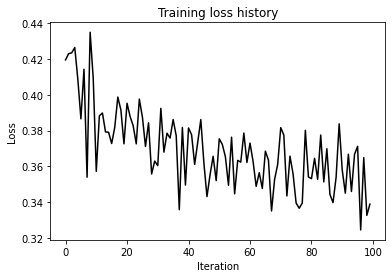

------------------------- Bootstrip 19 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.4516 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.4096 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3712 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3517 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3920 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3874 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3981 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3871 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3670 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3752 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3968 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3817 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3809 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3918 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3540 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3667 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3821 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3672 time per epoch: 0.1s
(Ep

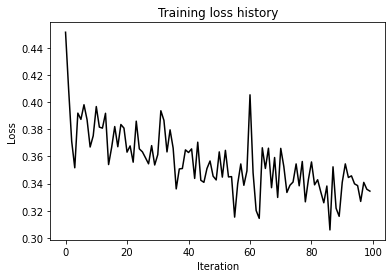

------------------------- Bootstrip 20 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.4070 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.3853 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3739 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3865 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3333 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3702 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3702 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3581 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3688 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3396 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3703 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3489 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3627 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3528 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3570 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3453 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3400 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3431 time per epoch: 0.1s
(Ep

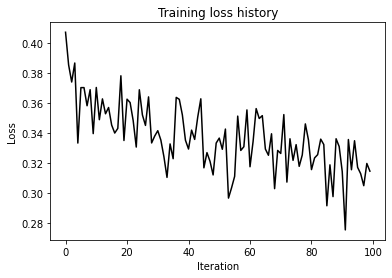

------------------------- Bootstrip 21 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.4201 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.3763 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3693 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3889 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3480 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3675 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3491 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3661 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3361 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3412 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3475 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3721 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3443 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3726 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3287 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3279 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3438 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3851 time per epoch: 0.1s
(Ep

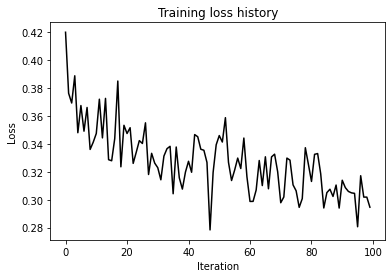

------------------------- Bootstrip 22 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3754 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.3680 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3486 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3407 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3332 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3219 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3242 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3461 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3232 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3288 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3019 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2910 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3208 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3285 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3056 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3303 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3106 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3027 time per epoch: 0.1s
(Ep

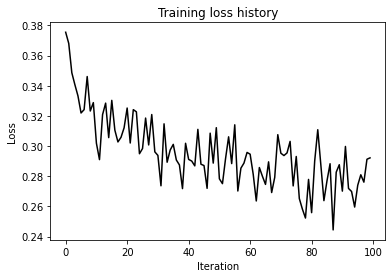

------------------------- Bootstrip 23 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3885 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.3417 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3700 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3574 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3321 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3449 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3353 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3359 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3355 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3096 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3406 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3339 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3159 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3347 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3514 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3341 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2932 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3283 time per epoch: 0.1s
(Ep

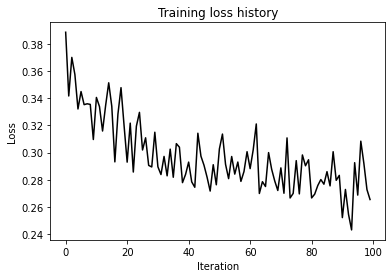

------------------------- Bootstrip 24 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3418 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2767 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2906 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2708 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2792 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2876 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3076 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3227 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2930 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2936 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2789 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2778 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2672 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2813 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2712 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2684 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3061 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2780 time per epoch: 0.1s
(Ep

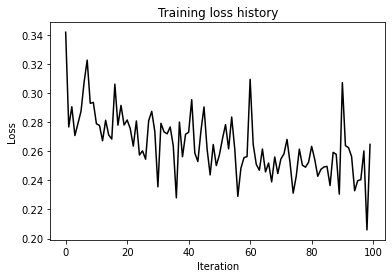

------------------------- Bootstrip 25 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3732 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.3505 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3489 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3364 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3111 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3302 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.3413 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3352 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.3370 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.3394 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.3216 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.3108 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.3011 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.3134 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.3050 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.3107 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.3093 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.3014 time per epoch: 0.1s
(Ep

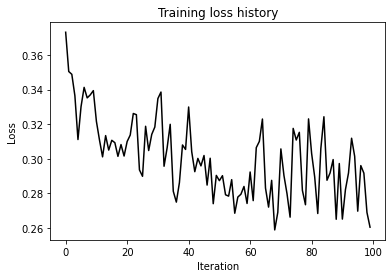

------------------------- Bootstrip 26 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3243 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2904 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3421 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2963 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2974 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2752 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2958 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2955 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2847 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2887 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2679 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2623 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2741 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2798 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2750 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2633 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2855 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2643 time per epoch: 0.1s
(Ep

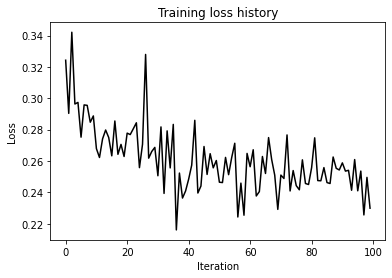

------------------------- Bootstrip 27 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3136 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.3023 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3257 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3184 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.3194 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.3284 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2867 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2929 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2669 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2904 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2877 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2915 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2933 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2866 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2651 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2722 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2731 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2516 time per epoch: 0.1s
(Ep

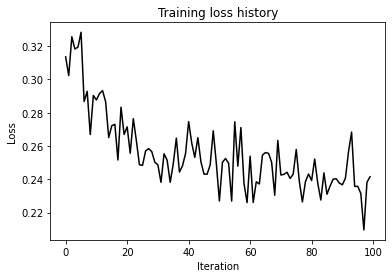

------------------------- Bootstrip 28 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3322 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2988 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.3159 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.3138 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2888 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2655 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2973 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.3197 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2965 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2801 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2683 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2827 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2427 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2869 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2625 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2816 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2869 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2743 time per epoch: 0.1s
(Ep

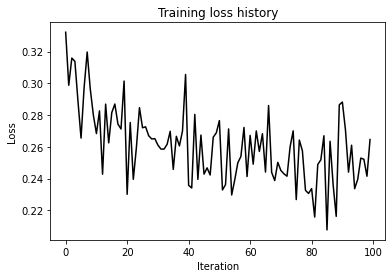

------------------------- Bootstrip 29 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3378 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2990 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2828 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2821 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2394 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2643 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2388 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2618 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2636 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2727 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2701 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2760 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2104 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2336 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2765 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2297 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2353 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2397 time per epoch: 0.1s
(Ep

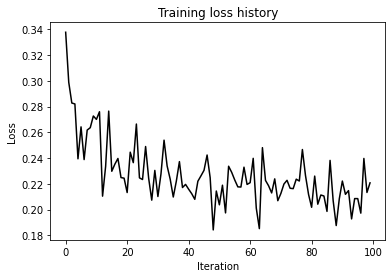

------------------------- Bootstrip 30 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2538 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2627 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2259 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2436 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2397 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1977 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2296 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2199 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2327 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2264 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2119 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2202 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2327 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2002 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2006 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2302 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1992 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1966 time per epoch: 0.1s
(Ep

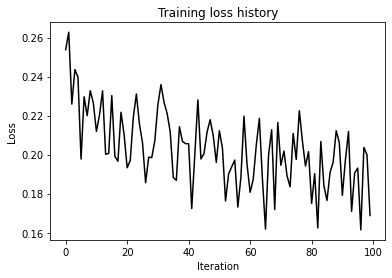

------------------------- Bootstrip 31 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.3138 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2767 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2788 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2840 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2476 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2290 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2494 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2618 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2779 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2217 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2362 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2382 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2475 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2434 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2333 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2270 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2236 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2147 time per epoch: 0.1s
(Ep

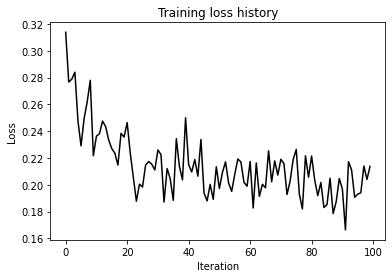

------------------------- Bootstrip 32 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2922 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2789 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2439 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2575 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2527 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2505 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2453 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2473 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2481 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2106 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2857 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2556 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2553 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2277 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2158 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2505 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2162 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2583 time per epoch: 0.1s
(Ep

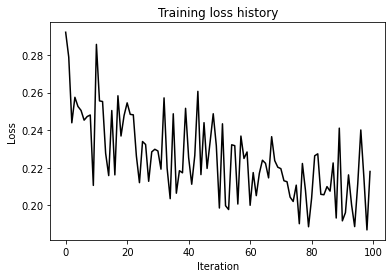

------------------------- Bootstrip 33 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2735 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2549 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2479 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2303 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2268 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2155 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2164 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2305 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2425 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2190 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2370 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2410 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2149 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2214 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2525 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2200 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2149 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2366 time per epoch: 0.1s
(Ep

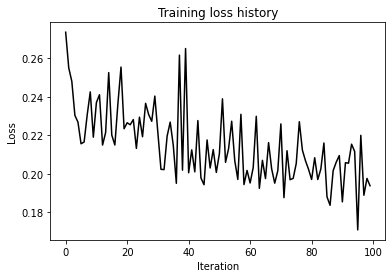

------------------------- Bootstrip 34 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2460 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2212 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2503 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2355 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2076 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2449 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2182 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2174 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2226 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2110 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2407 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2120 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1982 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2311 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1898 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2123 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2208 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1802 time per epoch: 0.1s
(Ep

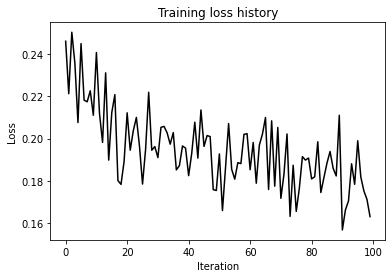

------------------------- Bootstrip 35 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2717 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2541 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2415 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2382 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2511 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2476 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2495 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2302 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2480 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1939 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2261 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2120 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2196 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.2182 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2010 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2184 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2012 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2195 time per epoch: 0.1s
(Ep

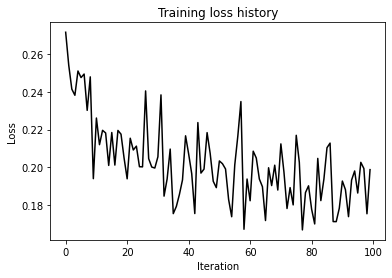

------------------------- Bootstrip 36 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2306 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2449 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2080 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2098 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2342 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2185 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2277 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2233 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2037 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2365 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2041 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2272 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2333 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1954 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1980 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.2119 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2252 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.2093 time per epoch: 0.1s
(Ep

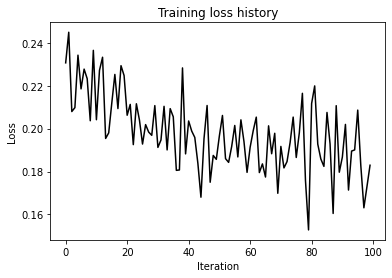

------------------------- Bootstrip 37 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2672 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2551 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2355 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2550 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2088 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2032 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2208 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2083 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2117 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2252 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1787 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.2016 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1939 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1825 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1957 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1927 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1819 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1872 time per epoch: 0.1s
(Ep

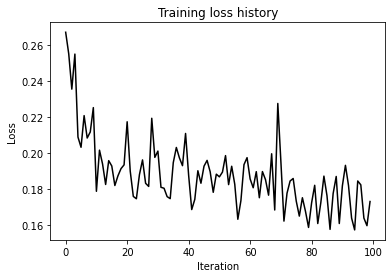

------------------------- Bootstrip 38 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2266 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2142 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2253 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2021 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2279 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1967 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2306 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1966 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2005 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2169 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2002 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1959 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1675 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1798 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1818 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1652 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1833 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1760 time per epoch: 0.1s
(Ep

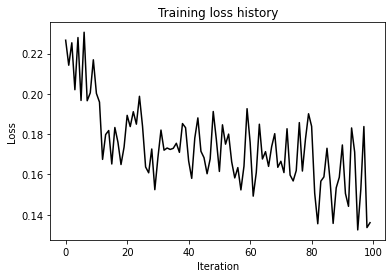

------------------------- Bootstrip 39 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2799 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2472 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2129 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2263 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2303 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2009 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.2155 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1953 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.2095 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1798 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1843 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1911 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.2066 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1975 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2031 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1941 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1929 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1771 time per epoch: 0.1s
(Ep

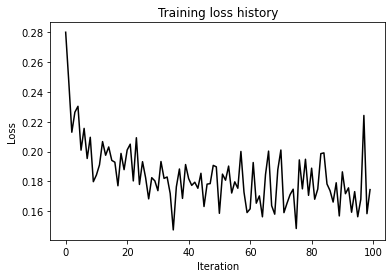

------------------------- Bootstrip 40 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2128 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.1708 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.1872 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1984 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1971 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.2134 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1806 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1761 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1825 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1722 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1648 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1876 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1694 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1897 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1861 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1735 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1664 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1771 time per epoch: 0.1s
(Ep

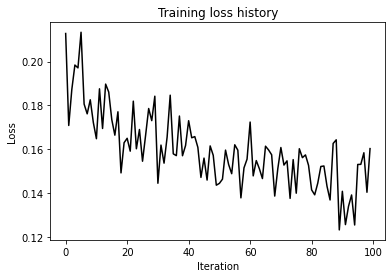

------------------------- Bootstrip 41 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2242 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2225 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2006 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2251 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1957 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1971 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1723 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1679 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1775 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2074 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1802 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1657 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1828 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1939 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.2061 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1798 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1739 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1607 time per epoch: 0.1s
(Ep

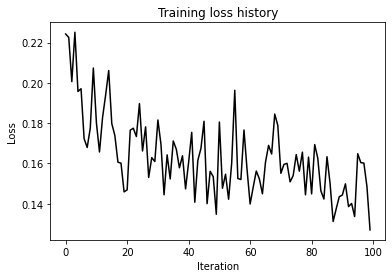

------------------------- Bootstrip 42 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.1991 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2224 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.1987 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2205 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.2214 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1929 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1885 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.2156 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1947 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.2032 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.2106 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1920 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1743 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1459 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1918 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1694 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1804 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1749 time per epoch: 0.1s
(Ep

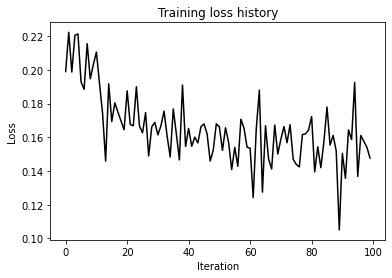

------------------------- Bootstrip 43 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2116 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.1948 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2408 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1901 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1688 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1703 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1636 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1794 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1736 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1918 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1708 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1605 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1615 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1630 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1622 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1766 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1622 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1567 time per epoch: 0.1s
(Ep

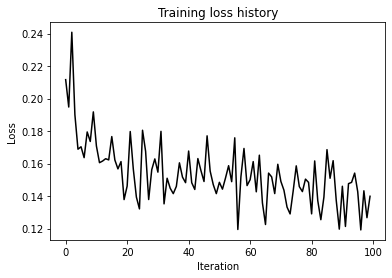

------------------------- Bootstrip 44 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.1893 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.1923 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2089 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1283 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1729 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1573 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1601 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1314 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1502 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1748 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1530 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1499 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1683 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1495 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1523 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1626 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1571 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1339 time per epoch: 0.1s
(Ep

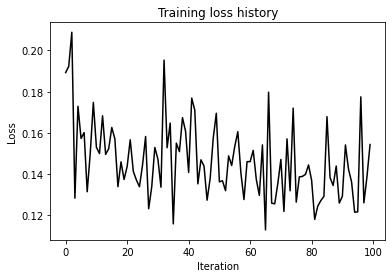

------------------------- Bootstrip 45 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2239 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.1859 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.1650 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1548 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1561 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1543 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1597 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1426 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1371 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1571 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1646 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1539 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1742 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1528 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1731 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1380 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1440 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1678 time per epoch: 0.1s
(Ep

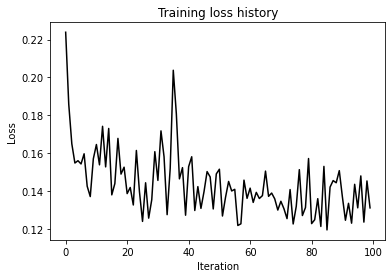

------------------------- Bootstrip 46 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2234 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2235 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.2040 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.2146 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1753 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1676 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1625 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1632 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1771 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1786 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1680 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1830 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1890 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1757 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1938 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1647 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.2131 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1899 time per epoch: 0.1s
(Ep

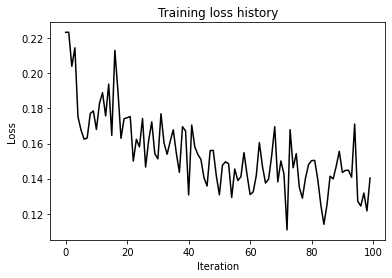

------------------------- Bootstrip 47 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.1928 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.2369 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.1537 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1470 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1959 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1670 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1524 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1495 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1570 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1523 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1847 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1348 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1719 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1469 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1651 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1599 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1488 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1311 time per epoch: 0.1s
(Ep

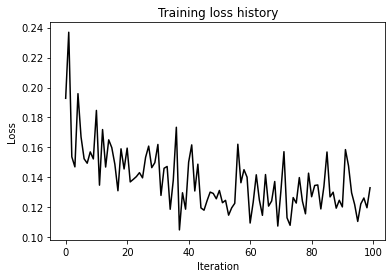

------------------------- Bootstrip 48 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.1936 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.1898 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.1667 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1611 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1709 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1535 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1431 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1614 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1604 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1667 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1400 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1483 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1429 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1665 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1480 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1241 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1471 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1499 time per epoch: 0.1s
(Ep

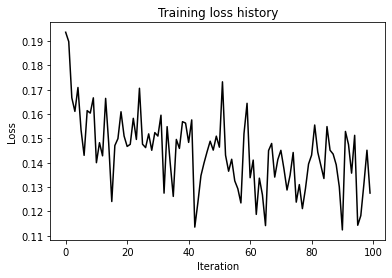

------------------------- Bootstrip 49 ------------------------
learning rate is:  0.001
(Epoch 0 / 100) loss: 0.2009 time per epoch: 0.1s
(Epoch 1 / 100) loss: 0.1606 time per epoch: 0.1s
(Epoch 2 / 100) loss: 0.1641 time per epoch: 0.1s
(Epoch 3 / 100) loss: 0.1614 time per epoch: 0.1s
(Epoch 4 / 100) loss: 0.1629 time per epoch: 0.1s
(Epoch 5 / 100) loss: 0.1683 time per epoch: 0.1s
(Epoch 6 / 100) loss: 0.1550 time per epoch: 0.1s
(Epoch 7 / 100) loss: 0.1433 time per epoch: 0.1s
(Epoch 8 / 100) loss: 0.1575 time per epoch: 0.1s
(Epoch 9 / 100) loss: 0.1314 time per epoch: 0.1s
(Epoch 10 / 100) loss: 0.1305 time per epoch: 0.1s
(Epoch 11 / 100) loss: 0.1212 time per epoch: 0.1s
(Epoch 12 / 100) loss: 0.1392 time per epoch: 0.1s
(Epoch 13 / 100) loss: 0.1252 time per epoch: 0.1s
(Epoch 14 / 100) loss: 0.1189 time per epoch: 0.1s
(Epoch 15 / 100) loss: 0.1277 time per epoch: 0.1s
(Epoch 16 / 100) loss: 0.1576 time per epoch: 0.1s
(Epoch 17 / 100) loss: 0.1486 time per epoch: 0.1s
(Ep

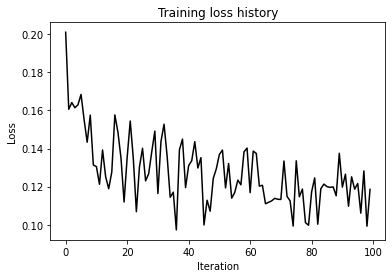

In [31]:
#bootstrap sample
import random
B=50
probB = torch.empty(1,4)  #initialize probability training set 
probB_train = torch.empty(1, 4)  #initialize probability test set

for b in range(B):
  print('------------------------- Bootstrip %s ------------------------'%(b) )
  index_b = random.choices(range(Pointdata_train.shape[0]) , k=Pointdata_train.shape[0])
  Pointdata_train_b = Pointdata_train[index_b]
  Seqdata_train_b = Seqdata_train[index_b]
  class_y_train_b = class_y_train[index_b]

  num_epochs = 100
  batch_size = 1191 
  learning_rate = 1e-3
  rnn_dnn_model_UQ = RNN_DNN_UQ( 
            cell_type='lstm',
            input_dim = 2,     #Seqdata_train.shape[2]
            input_dim_v = 25,  #Pointdata_train.shape[1],
            input_dim_t= 50,   #Seqdata_train.shape[1], 
            proj_dim = 10,
            C=4, 
            hidden_dim = 1, 
            reg = 0.0, 
            dropratio = 0.5, 
            DNN_hidden_Size=[256, 1024, 2048, 1024, 512],  #str11
            **to_float_cuda)

  print('learning rate is: ', learning_rate)
  ModelTrain(rnn_dnn_model_UQ, Pointdata_train_b, Seqdata_train_b, class_y_train_b, 
                  num_epochs=num_epochs, batch_size=batch_size,
                  learning_rate=learning_rate)

  rnn_dnn_model_UQ = rnn_dnn_model_UQ.eval()  
  y_pred_train_b, y_pred_prob_train_b = rnn_dnn_model_UQ.test_process(Pointdata_train_b, Seqdata_train_b)
  y_pred_train_b, y_pred_prob_train_b = y_pred_train_b.to('cpu'), y_pred_prob_train_b.to('cpu')
  y_pred_b, y_pred_prob_b = rnn_dnn_model_UQ.test_process(Pointdata_test, Seqdata_test)
  y_pred_b, y_pred_prob_b = y_pred_b.to('cpu'), y_pred_prob_b.to('cpu')
  probB = torch.cat([probB,   y_pred_prob_b[0].data.reshape(1,4)], dim = 0)
  probB_train = torch.cat((probB_train, y_pred_prob_train_b[0].data.reshape(1,4)), dim=0)

probB = probB[1:]  # remove the initialized prob
probB_train = probB_train[1:] # remove the initialized prob

In [39]:
probB

tensor([[-1.2085e+02,  0.0000e+00,  3.3631e-44,  0.0000e+00],
        [ 3.3096e-01,  1.5622e-01,  3.6389e-01,  1.4893e-01],
        [ 3.3131e-01,  1.8119e-01,  2.6254e-01,  2.2496e-01],
        [ 3.9088e-01,  1.3940e-01,  3.2693e-01,  1.4279e-01],
        [ 4.5757e-01,  1.6697e-01,  2.8694e-01,  8.8510e-02],
        [ 4.8405e-01,  2.0927e-01,  2.8454e-01,  2.2137e-02],
        [ 6.4138e-01,  2.6355e-01,  6.1414e-02,  3.3652e-02],
        [ 7.3001e-01,  2.0685e-01,  5.7323e-02,  5.8240e-03],
        [ 8.3941e-01,  1.5120e-01,  8.7293e-03,  6.5962e-04],
        [ 6.4475e-01,  3.4827e-01,  6.4400e-03,  5.4008e-04],
        [ 7.6381e-01,  2.2892e-01,  7.2066e-03,  6.6572e-05],
        [ 8.4719e-01,  1.5117e-01,  1.6132e-03,  1.9514e-05],
        [ 7.7618e-01,  2.2065e-01,  3.1534e-03,  1.1686e-05],
        [ 9.0749e-01,  9.0840e-02,  1.6253e-03,  4.6923e-05],
        [ 8.7983e-01,  1.1746e-01,  2.6910e-03,  1.6942e-05],
        [ 8.1611e-01,  1.8326e-01,  6.2638e-04,  4.1460e-06],
        